<h3 align="center"><font color='#13005A' size=6>Customer Churn Prediction Model</font></h3>

<div align="center" style="background-color: #1F13DB;">
<img src="https://content.webengage.com/wp-content/uploads/sites/4/2021/08/Reduce-churn-Rate-02.jpg" width="600" align="center"/>
</div>

<div align="center" style="background-color: #865DFF; padding:10px;"><font color='#B3005E' size=5>Business Problem</font></div>

<font color='#13005A' size=4>A machine learning model is expected to be developed to predict customers who will leave the company.</font>

<div align="center" style="background-color: #865DFF; padding:10px;"><font color='#B3005E' size=5>Variables</font></div>

<div align="center"">
<img src="churnvariables.png" width="700" align="left"/>
</div>

<div align="center" style="background-color: #865DFF; padding:10px;"><font color='#B3005E' size=5>Imports & Settings</font></div>

In [141]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from colorama import Fore

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler, LabelEncoder, StandardScaler, RobustScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, auc
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV, cross_validate, train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier

# !pip install optuna
import optuna

import warnings
warnings.simplefilter(action="ignore")

pd.set_option('display.max_columns', None)  # display all columns
pd.set_option('display.width', None)  # auto-size the column width
pd.set_option('display.float_format', lambda x: '%.3f' % x)

<div align="center" style="background-color: #865DFF; padding:10px;"><font color='#B3005E' size=5>Data Understanding</font></div>

In [7]:
def load_data():
    data = pd.read_csv('Telco-Customer-Churn.csv')
    return data

In [8]:
df = load_data()
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.850,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.950,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.850,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.300,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.700,151.65,Yes


In [9]:
def check_df(dataframe, head=5):
    print(Fore.BLUE+' COLUMNS '.center(125, '~'),'\n')
    print(Fore.BLACK, dataframe.columns,'\n')
    print(Fore.BLUE+' HEAD '.center(125, '~'),'\n')
    print(Fore.BLACK, dataframe.head(),'\n')
    print(Fore.BLUE+' TAIL '.center(125, '~'),'\n')
    print(Fore.BLACK, dataframe.tail(),'\n')
    print(Fore.BLUE+' TYPES '.center(125, '~'),'\n')
    print(Fore.BLACK, dataframe.dtypes,'\n')
    print(Fore.BLUE+' INFO '.center(125, '~'),Fore.BLACK,'\n')
    print(Fore.BLACK, dataframe.info(),'\n')
    print(Fore.BLUE+' MISSING VALUES '.center(125, '~'),'\n')
    print(Fore.BLACK, dataframe.isnull().sum(),'\n')
    print(Fore.BLUE+' QUANTILES '.center(125, '~'),'\n')
    print(Fore.BLACK, dataframe.describe([0.05,0.10,0.25,0.50,0.75,0.90,0.95,0.99]).drop('count').T,'\n')

check_df(df)

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ COLUMNS ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ 

 Index(['customerID', 'gender', 'SeniorCitizen', 'Partner', 'Dependents',
       'tenure', 'PhoneService', 'MultipleLines', 'InternetService',
       'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport',
       'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling',
       'PaymentMethod', 'MonthlyCharges', 'TotalCharges', 'Churn'],
      dtype='object') 

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ HEAD ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ 

    customerID  gender  SeniorCitizen Partner Dependents  tenure PhoneService  \
0  7590-VHVEG  Female              0     Yes         No       1           No   
1  5575-GNVDE    Male              0      No         No      34          Yes   
2  3668-QPYBK    Male              0      No         No       2          Yes   
3  7795-CFOCW    Male              0   

In [10]:
# Changing the type of 'TotalCharges' from Object to Float
df["TotalCharges"] = pd.to_numeric(df["TotalCharges"], errors='coerce')

# Changing the value of Target variable Churn from ['Yes', 'No'] to [1, 0]
df["Churn"] = df["Churn"].apply(lambda x: 1 if x == "Yes" else 0)

# Tenure variable has values of 0. Therefore, I will add 1 to the values of the tenure variable because
# it can cause problems in possible mathematical operations when generating variables.
df["tenure"] = df["tenure"] + 1

<div align="center" style="background-color: #865DFF; padding:10px;"><font color='#B3005E' size=5>Categorical and Numerical Variables</font></div>

In [11]:
# This function grabs categorical and numerical variables.
def grab_col_names(dataframe, cat_th=10, car_th=20):
    
    """

    This function provides the names of the categorical, numerical, and categorical but cardinal variables in the dataset.
    Note: Numerical-appearing categorical variables are also included in the categorical variable list.

    Parameters
    ------
        dataframe: dataframe
            The dataframe of which variable names will be obtained.
        cat_th: int, optional
            Class threshold value for numerical but categorical variables
        car_th: int, optinal
            Class threshold value for categorical but cardinal variables

    Returns
    ------
        cat_cols: list
            Categorical variable list
        num_cols: list
            Numerical variable list
        cat_but_car: list
            Categorical-appearing but cardinal variable list

    Examples
    ------
        import seaborn as sns
        df = sns.load_dataset("iris")
        print(grab_col_names(df))


    Notes
    ------
        num_but_cat is included in cat_cols.
        The sum of the returned 3 lists is equal to the total number of variables:
        cat_cols + num_cols + cat_but_car = total number of variables.  
        Numerical variables that number of unique values are lower than cat_th(10) named as categorical 

    """

    # cat_cols, cat_but_car
    cat_cols = [col for col in dataframe.columns if dataframe[col].dtypes == "O"]
    num_but_cat = [col for col in dataframe.columns if dataframe[col].nunique() < cat_th and dataframe[col].dtypes != "O"]
    cat_but_car = [col for col in dataframe.columns if dataframe[col].nunique() > car_th and dataframe[col].dtypes == "O"]
    cat_cols = cat_cols + num_but_cat
    cat_cols = [col for col in cat_cols if col not in cat_but_car]

    # num_cols
    num_cols = [col for col in dataframe.columns if dataframe[col].dtypes != "O"]
    num_cols = [col for col in num_cols if col not in num_but_cat]

    print(f"Observations: {dataframe.shape[0]}")
    print(f"Variables: {dataframe.shape[1]}")
    print(f'cat_cols: {len(cat_cols)}')
    print(f'num_cols: {len(num_cols)}')
    print(f'cat_but_car: {len(cat_but_car)}')
    print(f'num_but_cat: {len(num_but_cat)}')
    return cat_cols, num_cols, cat_but_car

cat_cols, num_cols, cat_but_car = grab_col_names(df)

Observations: 7043
Variables: 21
cat_cols: 17
num_cols: 3
cat_but_car: 1
num_but_cat: 2


<div align="center" style="background-color: #865DFF; padding:10px;"><font color='#B3005E' size=5>Categorical Variable Analysis</font></div>

        gender  Ratio
Male      3555 50.476
Female    3488 49.524


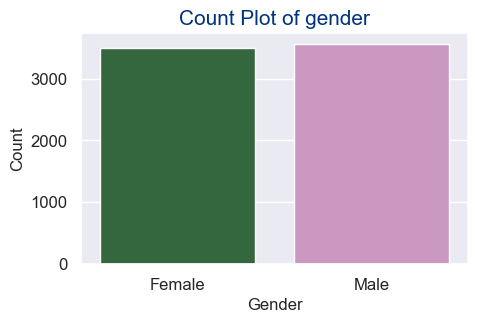

##########################################################################

     Partner  Ratio
No      3641 51.697
Yes     3402 48.303


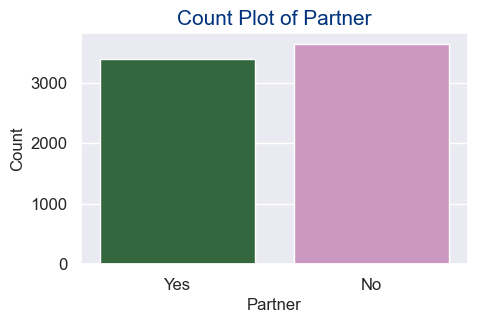

##########################################################################

     Dependents  Ratio
No         4933 70.041
Yes        2110 29.959


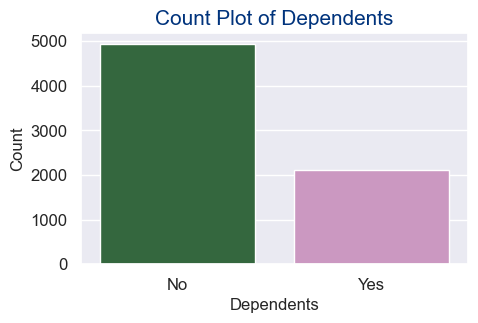

##########################################################################

     PhoneService  Ratio
Yes          6361 90.317
No            682  9.683


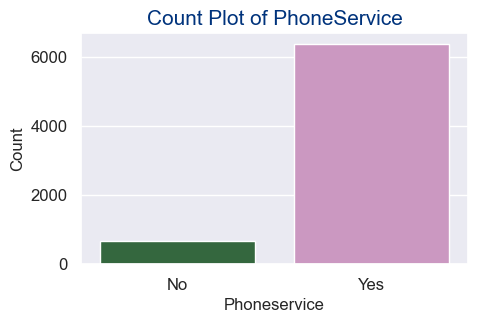

##########################################################################

                  MultipleLines  Ratio
No                         3390 48.133
Yes                        2971 42.184
No phone service            682  9.683


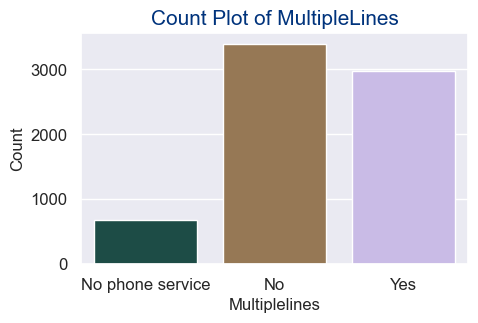

##########################################################################

             InternetService  Ratio
Fiber optic             3096 43.959
DSL                     2421 34.375
No                      1526 21.667


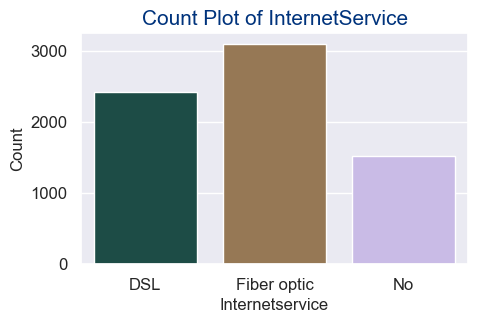

##########################################################################

                     OnlineSecurity  Ratio
No                             3498 49.666
Yes                            2019 28.667
No internet service            1526 21.667


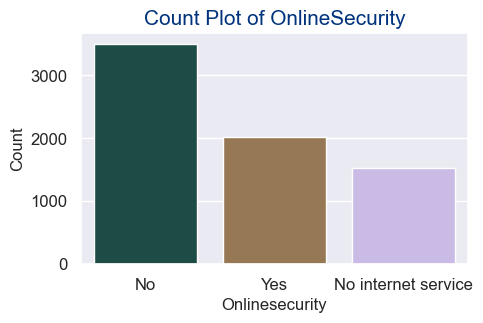

##########################################################################

                     OnlineBackup  Ratio
No                           3088 43.845
Yes                          2429 34.488
No internet service          1526 21.667


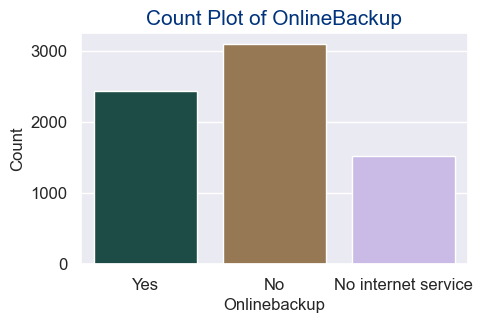

##########################################################################

                     DeviceProtection  Ratio
No                               3095 43.944
Yes                              2422 34.389
No internet service              1526 21.667


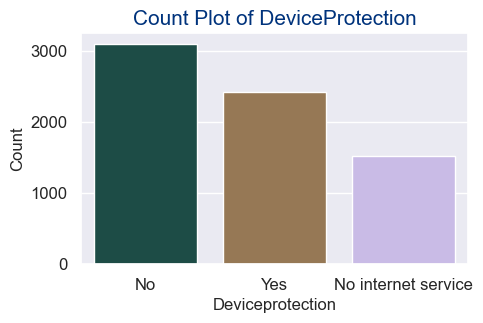

##########################################################################

                     TechSupport  Ratio
No                          3473 49.311
Yes                         2044 29.022
No internet service         1526 21.667


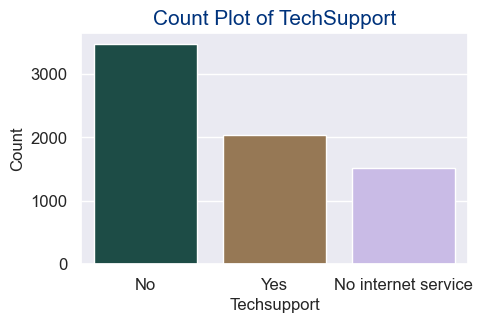

##########################################################################

                     StreamingTV  Ratio
No                          2810 39.898
Yes                         2707 38.435
No internet service         1526 21.667


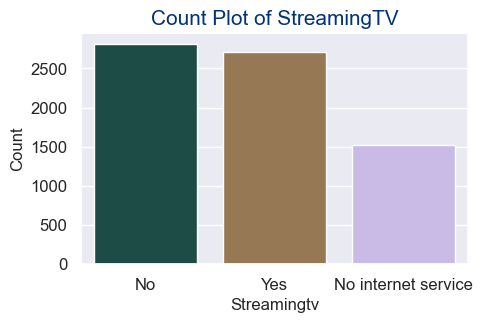

##########################################################################

                     StreamingMovies  Ratio
No                              2785 39.543
Yes                             2732 38.790
No internet service             1526 21.667


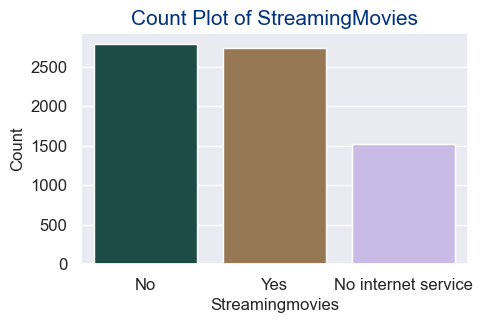

##########################################################################

                Contract  Ratio
Month-to-month      3875 55.019
Two year            1695 24.066
One year            1473 20.914


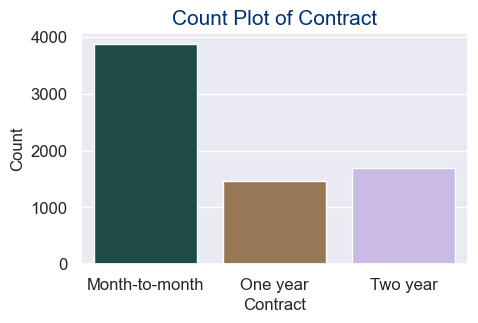

##########################################################################

     PaperlessBilling  Ratio
Yes              4171 59.222
No               2872 40.778


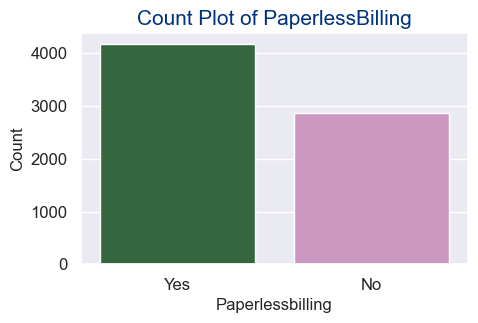

##########################################################################

                           PaymentMethod  Ratio
Electronic check                    2365 33.579
Mailed check                        1612 22.888
Bank transfer (automatic)           1544 21.922
Credit card (automatic)             1522 21.610


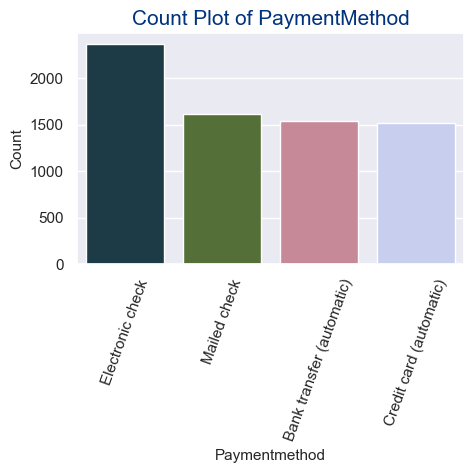

##########################################################################

   SeniorCitizen  Ratio
0           5901 83.785
1           1142 16.215


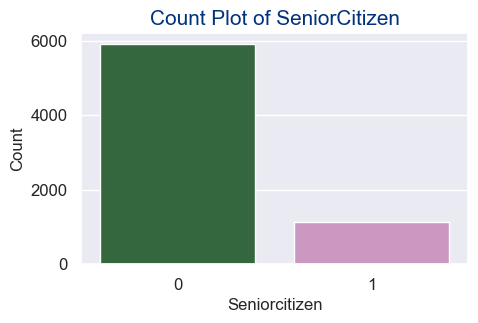

##########################################################################

   Churn  Ratio
0   5174 73.463
1   1869 26.537


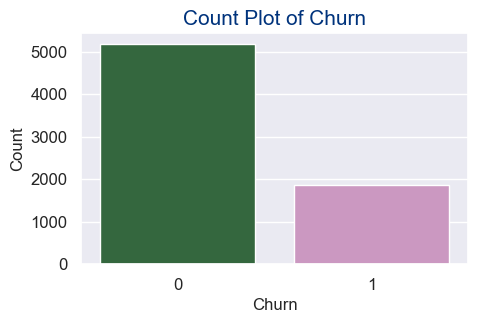

##########################################################################



In [12]:
# Information about the categorical variables
def cat_summary(dataframe, col_name, plot=False):
    counts = dataframe[col_name].value_counts()
    ratios = 100 * counts / len(dataframe)
    summary_df = pd.DataFrame({col_name: counts, "Ratio": ratios})
    print(summary_df)
    if plot:
        sns.set(style="darkgrid")
        if (dataframe[col_name].nunique() > 3):
            
            fig, ax = plt.subplots(figsize=(5, 3))
            ax.set_title(f"Count Plot of {col_name}", color="#00337C", fontsize=15)

            # Create the count plot
            sns.countplot(x=dataframe[col_name], data=dataframe, ax=ax, palette="cubehelix")
            ax.set_xlabel(col_name.capitalize(), fontsize=11)
            ax.set_ylabel("Count", fontsize=11)
            ax.tick_params(labelsize=11)
            ax.set_xticklabels(ax.get_xticklabels(), rotation=70)
            plt.show(block=True)
            print("##########################################################################\n")

        else:
            # Set the figure size and title
            fig, ax = plt.subplots(figsize=(5, 3))
            ax.set_title(f"Count Plot of {col_name}", color="#00337C", fontsize=15)

            # Create the count plot
            sns.countplot(x=dataframe[col_name], data=dataframe, ax=ax, palette="cubehelix")
            ax.set_xlabel(col_name.capitalize(), fontsize=12)
            ax.set_ylabel("Count", fontsize=12)
            ax.tick_params(labelsize=12)
            plt.show(block=True)
            print("##########################################################################\n")
    else:
        print(summary_df)         

for col in cat_cols:
    cat_summary(df, col, plot=True)

<font size=5 color='#00337C'>Observations</font>

<font color='#000' size=3>✦ Approximately half of the customers in our dataset are male, and the other half are female.</font><br>
<font color='#000' size=3>✦ About 50% of the customers have a partner (married).</font><br>
<font color='#000' size=3>✦ Only 30% of the total customers have dependents.</font><br>
<font color='#000' size=3>✦ 90% of the customers have phone service.</font><br>
<font color='#000' size=3>✦ Among those who have phone service, 53% do not have multiple lines.</font><br>
<font color='#000' size=3>✦ 21% of the customers do not have an internet service provider.</font><br>
<font color='#000' size=3>✦ Most of the customers are on a month-to-month contract. There are roughly equal numbers of customers with one-year and two-year contracts.</font><br>
<font color='#000' size=3>✦ 60% of the customers have paperless billing.</font><br>
<font color='#000' size=3>✦ About 26% of the customers have churned (i.e., left the platform) in the last month.</font><br>
<font color='#000' size=3>✦ 16% of the dataset consists of elderly customers. Therefore, most of the customers in the data are young.</font>

<div align="center" style="background-color: #865DFF; padding:10px;"><font color='#B3005E' size=5>Numerical Variable Analysis</font></div>

tenure Descriptive Statistics

count   7043.000
mean      33.371
std       24.559
min        1.000
5%         2.000
10%        3.000
25%       10.000
50%       30.000
75%       56.000
90%       70.000
95%       73.000
max       73.000
Name: tenure, dtype: float64


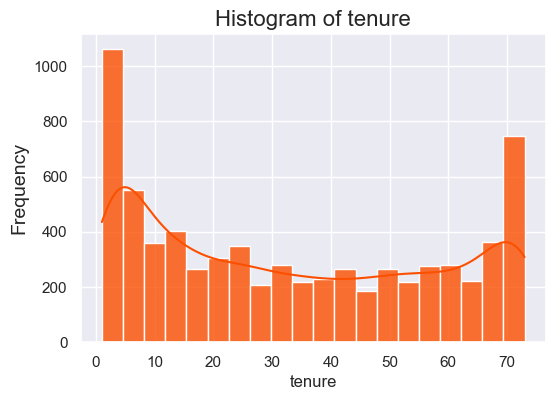

MonthlyCharges Descriptive Statistics

count   7043.000
mean      64.762
std       30.090
min       18.250
5%        19.650
10%       20.050
25%       35.500
50%       70.350
75%       89.850
90%      102.600
95%      107.400
max      118.750
Name: MonthlyCharges, dtype: float64


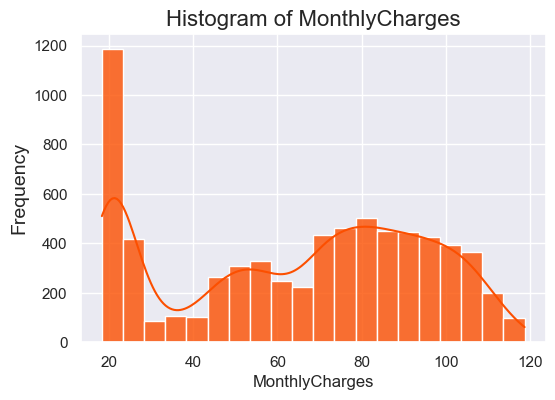

TotalCharges Descriptive Statistics

count   7032.000
mean    2283.300
std     2266.771
min       18.800
5%        49.605
10%       84.600
25%      401.450
50%     1397.475
75%     3794.738
90%     5976.640
95%     6923.590
max     8684.800
Name: TotalCharges, dtype: float64


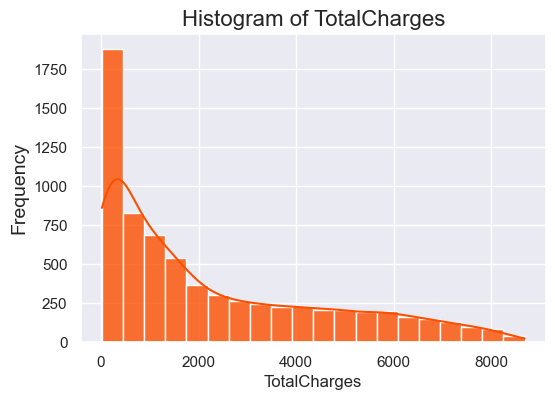

In [13]:
# Information about the numerical variables
def num_summary(dataframe, numerical_col, plot=False):
    quantiles = [0.05, 0.10, 0.25, 0.50, 0.75, 0.90, 0.95]
    summary_df = dataframe[numerical_col].describe(quantiles).T
    print(f"\033[1m\033[36m{numerical_col} Descriptive Statistics\n\033[0m")
    print(summary_df)

    if plot:
        plt.figure(figsize=(6, 4))
        sns.set(style="darkgrid")
        sns.histplot(x=dataframe[numerical_col], bins=20, kde=True, color="#FC4F00", edgecolor="#FFFFFF", alpha=0.8,
                     )
        plt.title(f"Histogram of {numerical_col}", fontsize=16)
        plt.ylabel("Frequency", fontsize=14)
        plt.show(block=True)
   
for col in num_cols:
    num_summary(df, col, plot=True)

<font size=5 color='#00337C'>Observations</font>

<font color='#000' size=3>✦ When we look at Tenure, we see that there are a lot of customers with a tenure of 1 month, followed by customers with a tenure of 70 months.</font>

<div align="center" style="background-color: #865DFF; padding:10px;"><font color='#B3005E' size=5>Analysis of Numerical Variables by Target</font></div>

 Mean of numerical columns grouped by target variable 

       tenure  MonthlyCharges  TotalCharges
Churn                                      
0      38.570          61.265      2555.344
1      18.979          74.441      1531.796


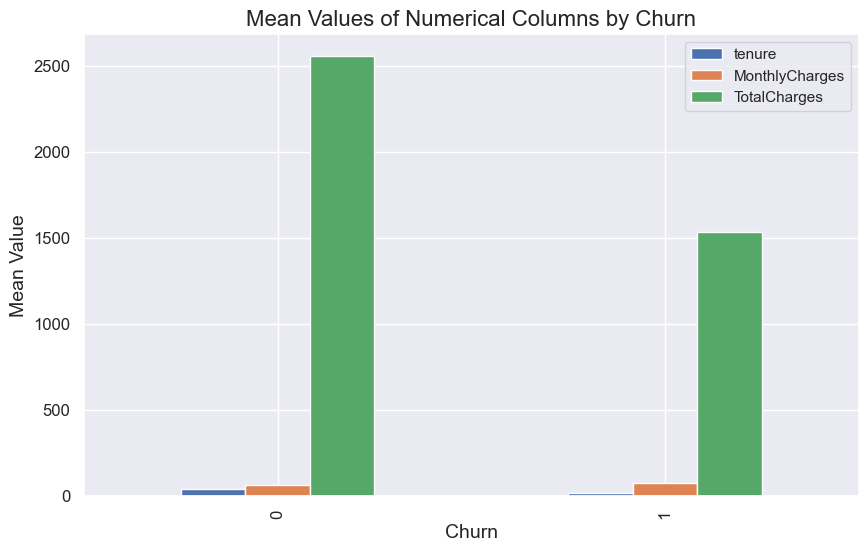

In [14]:
# Target variable is 'Outcome'
def target_summary_with_num(dataframe, target, numerical_col):
    num_means = df.groupby(target).agg({col: 'mean' for col in num_cols})
    print(f"\033[1m\033[36m Mean of numerical columns grouped by target variable \n\033[0m")
    print(num_means)

    # Create bar plot
    ax = num_means.plot(kind='bar', figsize=(10, 6), fontsize=12)
    ax.set_title("Mean Values of Numerical Columns by Churn", fontsize=16)
    ax.set_xlabel("Churn", fontsize=14)
    ax.set_ylabel("Mean Value", fontsize=14)
    plt.show()

target_summary_with_num(df, 'Churn', num_cols)

<font size=5 color='#00337C'>Observations</font>

<font color='#000' size=3>✦ When we look at the relationship between Tenure and Churn, we see that customers who do not churn have been customers for a longer period of time.</font><br>
<font color='#000' size=3>✦ When Monthly Charges and Churn are examined, we see that customers who churn have a higher average monthly payment.</font>

<div align="center" style="background-color: #865DFF; padding:10px;"><font color='#B3005E' size=5>Analysis of Categorical Variables by Target</font></div>

In [15]:
def target_summary_with_cat(dataframe, target, categorical_col):
    print(categorical_col)
    print(pd.DataFrame({"TARGET_MEAN": dataframe.groupby(categorical_col)[target].mean(),
                        "Count": dataframe[categorical_col].value_counts(),
                        "Ratio": 100 * dataframe[categorical_col].value_counts() / len(dataframe)}), end="\n\n\n")

for col in cat_cols:
    target_summary_with_cat(df, "Churn", col)

gender
        TARGET_MEAN  Count  Ratio
Female        0.269   3488 49.524
Male          0.262   3555 50.476


Partner
     TARGET_MEAN  Count  Ratio
No         0.330   3641 51.697
Yes        0.197   3402 48.303


Dependents
     TARGET_MEAN  Count  Ratio
No         0.313   4933 70.041
Yes        0.155   2110 29.959


PhoneService
     TARGET_MEAN  Count  Ratio
No         0.249    682  9.683
Yes        0.267   6361 90.317


MultipleLines
                  TARGET_MEAN  Count  Ratio
No                      0.250   3390 48.133
No phone service        0.249    682  9.683
Yes                     0.286   2971 42.184


InternetService
             TARGET_MEAN  Count  Ratio
DSL                0.190   2421 34.375
Fiber optic        0.419   3096 43.959
No                 0.074   1526 21.667


OnlineSecurity
                     TARGET_MEAN  Count  Ratio
No                         0.418   3498 49.666
No internet service        0.074   1526 21.667
Yes                        0.146   2019 28.667


O

<font size=5 color='#00337C'>Observations</font>

<font color='#000' size=3>✦ Churn percentage is almost equal for both men and women.</font><br>
<font color='#000' size=3>✦ Customers with partner and dependents have a lower churn rate.</font><br>
<font color='#000' size=3>✦ When Monthly Charges and Churn are examined, we see that customers who churn have a higher average monthly payment.</font><br>
<font color='#000' size=3>✦ There is no difference in churn rate for PhoneService and MultipleLines.</font><br>
<font color='#000' size=3>✦ The churn rate is much higher in Fiber Optic Internet Services.</font><br>
<font color='#000' size=3>✦ A larger percentage of customers with monthly subscriptions churn compared to customers with one or two-year contract subscriptions.</font><br>
<font color='#000' size=3>✦ Customers with paperless billing have a higher churn rate.</font><br>
<font color='#000' size=3>✦ Customers with ElectronicCheck PaymentMethod are more likely to churn compared to other options.</font><br>
<font color='#000' size=3>✦ The churn percentage is higher for elderly customers.</font><br>

<div align="center" style="background-color: #865DFF; padding:10px;"><font color='#B3005E' size=5>Correlation Analysis</font></div>

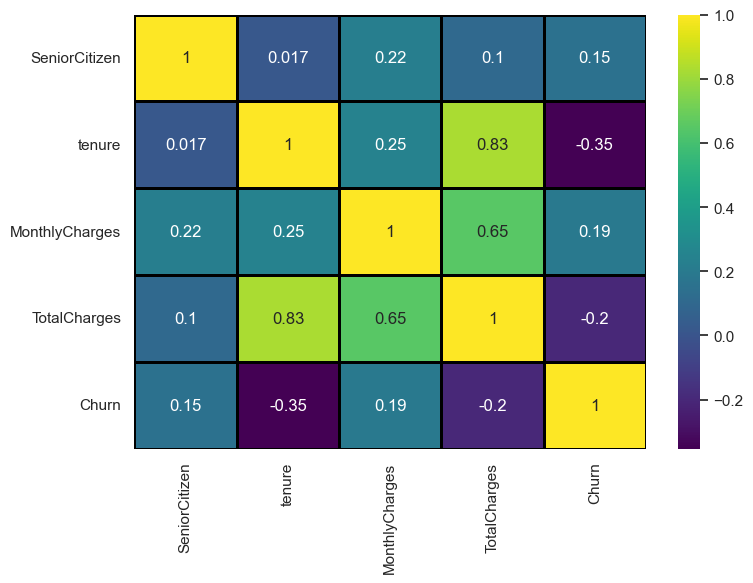

In [16]:
# Let's see if there is correlation between numerical values
plt.figure(figsize=(8, 6))
sns.heatmap(df.corr(), annot=True, linewidths=2, linecolor='black', cmap='viridis')
plt.tight_layout()
plt.show()

<font color='#282A3A' size=4>✦ TotalCharges appears to be highly correlated with MonthlyCharges and tenure</font>

<div align="center" style="background-color: #865DFF; padding:10px;"><font color='#B3005E' size=5>Missing Value Analysis</font></div>

In [17]:
df.isnull().sum()

customerID           0
gender               0
SeniorCitizen        0
Partner              0
Dependents           0
tenure               0
PhoneService         0
MultipleLines        0
InternetService      0
OnlineSecurity       0
OnlineBackup         0
DeviceProtection     0
TechSupport          0
StreamingTV          0
StreamingMovies      0
Contract             0
PaperlessBilling     0
PaymentMethod        0
MonthlyCharges       0
TotalCharges        11
Churn                0
dtype: int64

In [18]:
# We have only 11 missing values in 'TotalCharges' so ı will drop them.
df.drop(df[df['TotalCharges'].isnull()].index, axis=0, inplace=True)

<div align="center" style="background-color: #865DFF; padding:10px;"><font color='#B3005E' size=5>Outlier Analysis</font></div>

In [19]:
cat_cols, num_cols, cat_but_car = grab_col_names(df)

Observations: 7032
Variables: 21
cat_cols: 17
num_cols: 3
cat_but_car: 1
num_but_cat: 2


In [20]:
# I'm using the interquartile method to find the lower and upper limits. For this dataset,
# I have set the threshold values as 0.05 and 0.95.
def outlier_thresholds(dataframe, col_name, q1=0.05, q3=0.95):
    quartile1 = dataframe[col_name].quantile(q1)
    quartile3 = dataframe[col_name].quantile(q3)
    interquantile_range = quartile3 - quartile1
    up_limit = quartile3 + 1.5 * interquantile_range
    low_limit = quartile1 - 1.5 * interquantile_range
    return low_limit, up_limit

# Check if there is any outlier (True, False)
def check_outlier(dataframe, col_name):
    low_limit, up_limit = outlier_thresholds(dataframe, col_name)
    if dataframe[(dataframe[col_name] > up_limit) | (dataframe[col_name] < low_limit)].any(axis=None):
        return True
    else:
        return False

In [21]:
# Calling the function for numerical columns.
for col in num_cols:
    print(col, check_outlier(df, col))

tenure False
MonthlyCharges False
TotalCharges False


In [22]:
# There is a sudden increase between the 50th percentile and the 75th percentile and between the 95th percentile and
# the maximum value for the 'TotalCharges' variable, but it seems that it has not been captured by our threshold.
df.describe([0, 0.05, 0.10, 0.25, 0.50, 0.75, 0.90, 0.95, 0.99, 1]).T

,count,mean,std,min,0%,5%,10%,25%,50%,75%,90%,95%,99%,100%,max
SeniorCitizen,7032.000,0.162,0.369,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,1.000,1.000,1.000,1.000
tenure,7032.000,33.422,24.545,2.000,2.000,2.000,3.000,10.000,30.000,56.000,70.000,73.000,73.000,73.000,73.000
MonthlyCharges,7032.000,64.798,30.086,18.250,18.250,19.650,20.050,35.587,70.350,89.862,102.645,107.422,114.734,118.750,118.750
TotalCharges,7032.000,2283.300,2266.771,18.800,18.800,49.605,84.600,401.450,1397.475,3794.738,5976.640,6923.590,8039.883,8684.800,8684.800
Churn,7032.000,0.266,0.442,0.000,0.000,0.000,0.000,0.000,0.000,1.000,1.000,1.000,1.000,1.000,1.000


<div align="center" style="background-color: #865DFF; padding:10px;"><font color='#B3005E' size=5>Base Model</font></div>

In [23]:
dff = df.copy()
# Excluding our target variable for Encoding, it already has (0, 1) values.
cat_cols = [col for col in cat_cols if col not in ["Churn"]]
cat_cols

['gender',
 'Partner',
 'Dependents',
 'PhoneService',
 'MultipleLines',
 'InternetService',
 'OnlineSecurity',
 'OnlineBackup',
 'DeviceProtection',
 'TechSupport',
 'StreamingTV',
 'StreamingMovies',
 'Contract',
 'PaperlessBilling',
 'PaymentMethod',
 'SeniorCitizen']

In [24]:
# Using One-Hot encoding for converting categorical values to numerical.
def one_hot_encoder(dataframe, categorical_cols, drop_first=False):
    dataframe = pd.get_dummies(dataframe, columns=categorical_cols, drop_first=drop_first)
    return dataframe
dff = one_hot_encoder(dff, cat_cols, drop_first=True)

In [25]:
# Defining Target(dependent) and independent variables
y = dff["Churn"] # Target
X = dff.drop(["Churn","customerID"], axis=1) # Independent Variables

In [26]:
# Algorithms
models = [('LR', LogisticRegression(random_state=17)),
          ('KNN', KNeighborsClassifier()),
          ('CART', DecisionTreeClassifier(random_state=17)),
          ('RF', RandomForestClassifier(random_state=17)),
          ('XGB', XGBClassifier(random_state=17)),
          ("LightGBM", LGBMClassifier(random_state=17)),
          ("CatBoost", CatBoostClassifier(verbose=False, random_state=17))]

<h3 align="left"><font color='#00337C' size=5>Train Test Split</font></h3>

In [27]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=17)

In [28]:
for name, model in models:
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print(f"########## {name} ##########")
    print(f"Accuracy: {round(accuracy_score(y_test, y_pred), 4)}")
    print(f"Auc: {round(roc_auc_score(y_test, y_pred), 4)}")
    print(f"Recall: {round(recall_score(y_test, y_pred), 4)}")
    print(f"Precision: {round(precision_score(y_test, y_pred), 4)}")
    print(f"F1: {round(f1_score(y_test, y_pred), 4)}")

########## LR ##########
Accuracy: 0.8047
Auc: 0.7266
Recall: 0.5639
Precision: 0.6411
F1: 0.6
########## KNN ##########
Accuracy: 0.781
Auc: 0.6839
Recall: 0.4818
Precision: 0.5973
F1: 0.5333
########## CART ##########
Accuracy: 0.7142
Auc: 0.6447
Recall: 0.5
Precision: 0.4544
F1: 0.4761
########## RF ##########
Accuracy: 0.7943
Auc: 0.7017
Recall: 0.5091
Precision: 0.6284
F1: 0.5625
########## XGB ##########
Accuracy: 0.782
Auc: 0.7005
Recall: 0.531
Precision: 0.5891
F1: 0.5585
########## LightGBM ##########
Accuracy: 0.7991
Auc: 0.7269
Recall: 0.5766
Precision: 0.622
F1: 0.5985
########## CatBoost ##########
Accuracy: 0.8009
Auc: 0.7216
Recall: 0.5566
Precision: 0.6328
F1: 0.5922


<h3 align="left"><font color='#00337C' size=5>Cross Validation</font></h3>

In [29]:
for name, model in models:
    cv_results = cross_validate(model, X, y, cv=10, scoring=["accuracy", "f1", "roc_auc", "precision", "recall"])
    print(f"########## {name} ##########")
    print(f"Accuracy: {round(cv_results['test_accuracy'].mean(), 4)}")
    print(f"Auc: {round(cv_results['test_roc_auc'].mean(), 4)}")
    print(f"Recall: {round(cv_results['test_recall'].mean(), 4)}")
    print(f"Precision: {round(cv_results['test_precision'].mean(), 4)}")
    print(f"F1: {round(cv_results['test_f1'].mean(), 4)}")

########## LR ##########
Accuracy: 0.8049
Auc: 0.8426
Recall: 0.5468
Precision: 0.6606
F1: 0.598
########## KNN ##########
Accuracy: 0.7631
Auc: 0.7466
Recall: 0.4473
Precision: 0.5701
F1: 0.5007
########## CART ##########
Accuracy: 0.7301
Auc: 0.6622
Recall: 0.512
Precision: 0.493
F1: 0.5021
########## RF ##########
Accuracy: 0.7922
Auc: 0.827
Recall: 0.4853
Precision: 0.6458
F1: 0.5539
########## XGB ##########
Accuracy: 0.7868
Auc: 0.8245
Recall: 0.5083
Precision: 0.623
F1: 0.559
########## LightGBM ##########
Accuracy: 0.7961
Auc: 0.8369
Recall: 0.5168
Precision: 0.6471
F1: 0.5743
########## CatBoost ##########
Accuracy: 0.7981
Auc: 0.8406
Recall: 0.5104
Precision: 0.6552
F1: 0.5734


<div align="center" style="background-color: #865DFF; padding:10px;"><font color='#B3005E' size=5>Feature Engineering</font></div>

In [30]:
# Creating annual categorical variable from Tenure variable
df.loc[(df["tenure"]>=0) & (df["tenure"]<=12),"NEW_TENURE_YEAR"] = "0-1 Year"
df.loc[(df["tenure"]>12) & (df["tenure"]<=24),"NEW_TENURE_YEAR"] = "1-2 Year"
df.loc[(df["tenure"]>24) & (df["tenure"]<=36),"NEW_TENURE_YEAR"] = "2-3 Year"
df.loc[(df["tenure"]>36) & (df["tenure"]<=48),"NEW_TENURE_YEAR"] = "3-4 Year"
df.loc[(df["tenure"]>48) & (df["tenure"]<=60),"NEW_TENURE_YEAR"] = "4-5 Year"
df.loc[(df["tenure"]>60) & (df["tenure"]<=72),"NEW_TENURE_YEAR"] = "5-6 Year"

In [31]:
# Specify 1 or 2 year contract customers as Engaged
df["NEW_Engaged"] = df["Contract"].apply(lambda x: 1 if x in ["One year","Two year"] else 0)

In [32]:
# People who do not receive any support, backup or protection
df["NEW_noProt"] = df.apply(lambda x: 1 if (x["OnlineBackup"] != "Yes") or (x["DeviceProtection"] != "Yes") or (x["TechSupport"] != "Yes") else 0, axis=1)

In [33]:
# Customers with monthly contracts and young
df["NEW_Young_Not_Engaged"] = df.apply(lambda x: 1 if (x["NEW_Engaged"] == 0) and (x["SeniorCitizen"] == 0) else 0, axis=1)

In [34]:
# Total number of services received by the person
df['NEW_TotalServices'] = (df[['PhoneService', 'InternetService', 'OnlineSecurity',
                                       'OnlineBackup', 'DeviceProtection', 'TechSupport',
                                       'StreamingTV', 'StreamingMovies']] == 'Yes').sum(axis=1)

In [35]:
# People who buy any streaming service
df["NEW_FLAG_ANY_STREAMING"] = df.apply(lambda x: 1 if (x["StreamingTV"] == "Yes") or (x["StreamingMovies"] == "Yes") else 0, axis=1)

In [36]:
# Does the person make automatic payments?
df["NEW_FLAG_AutoPayment"] = df["PaymentMethod"].apply(lambda x: 1 if x in ["Bank transfer (automatic)","Credit card (automatic)"] else 0)

In [37]:
# Average monthly payment
df["NEW_AVG_Charges"] = df["TotalCharges"] / df["tenure"]

In [38]:
# Current Price increase relative to average price
df["NEW_Increase"] = df["NEW_AVG_Charges"] / df["MonthlyCharges"]

In [39]:
# Charge per service
df["NEW_AVG_Service_Fee"] = df["MonthlyCharges"] / (df['NEW_TotalServices'] + 1)

In [40]:
cat_cols, num_cols, cat_but_car = grab_col_names(df)

Observations: 7032
Variables: 31
cat_cols: 24
num_cols: 6
cat_but_car: 1
num_but_cat: 8


In [41]:
def label_encoder(dataframe, binary_col):
    labelencoder = LabelEncoder()
    dataframe[binary_col] = labelencoder.fit_transform(dataframe[binary_col])
    return dataframe

In [42]:
binary_cols = [col for col in df.columns if df[col].dtypes == "O" and df[col].nunique() == 2]
binary_cols

['gender', 'Partner', 'Dependents', 'PhoneService', 'PaperlessBilling']

In [43]:
for col in binary_cols:
    df = label_encoder(df, col)

In [44]:
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn,NEW_TENURE_YEAR,NEW_Engaged,NEW_noProt,NEW_Young_Not_Engaged,NEW_TotalServices,NEW_FLAG_ANY_STREAMING,NEW_FLAG_AutoPayment,NEW_AVG_Charges,NEW_Increase,NEW_AVG_Service_Fee
0,7590-VHVEG,0,0,1,0,2,0,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,1,Electronic check,29.850,29.850,0,0-1 Year,0,1,1,1,0,0,14.925,0.500,14.925
1,5575-GNVDE,1,0,0,0,35,1,No,DSL,Yes,No,Yes,No,No,No,One year,0,Mailed check,56.950,1889.500,0,2-3 Year,1,1,0,3,0,0,53.986,0.948,14.238
2,3668-QPYBK,1,0,0,0,3,1,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,1,Mailed check,53.850,108.150,1,0-1 Year,0,1,1,3,0,0,36.050,0.669,13.463
3,7795-CFOCW,1,0,0,0,46,0,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,0,Bank transfer (automatic),42.300,1840.750,0,3-4 Year,1,1,0,3,0,1,40.016,0.946,10.575
4,9237-HQITU,0,0,0,0,3,1,No,Fiber optic,No,No,No,No,No,No,Month-to-month,1,Electronic check,70.700,151.650,1,0-1 Year,0,1,1,1,0,0,50.550,0.715,35.350


In [45]:
cat_cols = [col for col in cat_cols if col not in binary_cols and col not in ["Churn", "NEW_TotalServices"]]
cat_cols

['MultipleLines',
 'InternetService',
 'OnlineSecurity',
 'OnlineBackup',
 'DeviceProtection',
 'TechSupport',
 'StreamingTV',
 'StreamingMovies',
 'Contract',
 'PaymentMethod',
 'NEW_TENURE_YEAR',
 'SeniorCitizen',
 'NEW_Engaged',
 'NEW_noProt',
 'NEW_Young_Not_Engaged',
 'NEW_FLAG_ANY_STREAMING',
 'NEW_FLAG_AutoPayment']

In [46]:
df = one_hot_encoder(df, cat_cols, drop_first=True)

In [47]:
df.head()

,customerID,gender,Partner,Dependents,tenure,PhoneService,PaperlessBilling,MonthlyCharges,TotalCharges,Churn,NEW_TotalServices,NEW_AVG_Charges,NEW_Increase,NEW_AVG_Service_Fee,MultipleLines_No phone service,MultipleLines_Yes,InternetService_Fiber optic,InternetService_No,OnlineSecurity_No internet service,OnlineSecurity_Yes,OnlineBackup_No internet service,OnlineBackup_Yes,DeviceProtection_No internet service,DeviceProtection_Yes,TechSupport_No internet service,TechSupport_Yes,StreamingTV_No internet service,StreamingTV_Yes,StreamingMovies_No internet service,StreamingMovies_Yes,Contract_One year,Contract_Two year,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,NEW_TENURE_YEAR_1-2 Year,NEW_TENURE_YEAR_2-3 Year,NEW_TENURE_YEAR_3-4 Year,NEW_TENURE_YEAR_4-5 Year,NEW_TENURE_YEAR_5-6 Year,SeniorCitizen_1,NEW_Engaged_1,NEW_noProt_1,NEW_Young_Not_Engaged_1,NEW_FLAG_ANY_STREAMING_1,NEW_FLAG_AutoPayment_1
0,7590-VHVEG,0,1,0,2,0,1,29.850,29.850,0,1,14.925,0.500,14.925,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,1,0,0
1,5575-GNVDE,1,0,0,35,1,0,56.950,1889.500,0,3,53.986,0.948,14.238,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,1,0,0,0,0,1,1,0,0,0
2,3668-QPYBK,1,0,0,3,1,1,53.850,108.150,1,3,36.050,0.669,13.463,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,1,0,0
3,7795-CFOCW,1,0,0,46,0,0,42.300,1840.750,0,3,40.016,0.946,10.575,1,0,0,0,0,1,0,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1,1,0,0,1
4,9237-HQITU,0,0,0,3,1,1,70.700,151.650,1,1,50.550,0.715,35.350,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,1,0,0


In [48]:
y = df["Churn"]
X = df.drop(["Churn","customerID"], axis=1)

In [49]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=17)
lgm = LGBMClassifier(random_state=17)
lgm.fit(X_train, y_train)
y_pred = lgm.predict(X_test)
print(f"########## LightGBM ##########")
print(f"Accuracy: {round(accuracy_score(y_test, y_pred), 4)}")
print(f"Auc: {round(roc_auc_score(y_test, y_pred), 4)}")
print(f"Recall: {round(recall_score(y_test, y_pred), 4)}")
print(f"Precision: {round(precision_score(y_test, y_pred), 4)}")
print(f"F1: {round(f1_score(y_test, y_pred), 4)}")

########## LightGBM ##########
Accuracy: 0.7929
Auc: 0.7103
Recall: 0.5383
Precision: 0.6159
F1: 0.5745


<div align="center" style="background-color: #865DFF; padding:10px;"><font color='#B3005E' size=5>Feature Importance</font></div>

In [50]:
def plot_importance(model, features, num=len(X), save=False):
    feature_imp = pd.DataFrame({'Value': model.feature_importances_, 'Feature': features.columns})
    plt.figure(figsize=(10, 10))
    sns.set(font_scale=1)
    sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value",
                                                                     ascending=False)[0:num])
    plt.title('Features')
    plt.tight_layout()
    plt.show()
    if save:
        plt.savefig('importances.png')

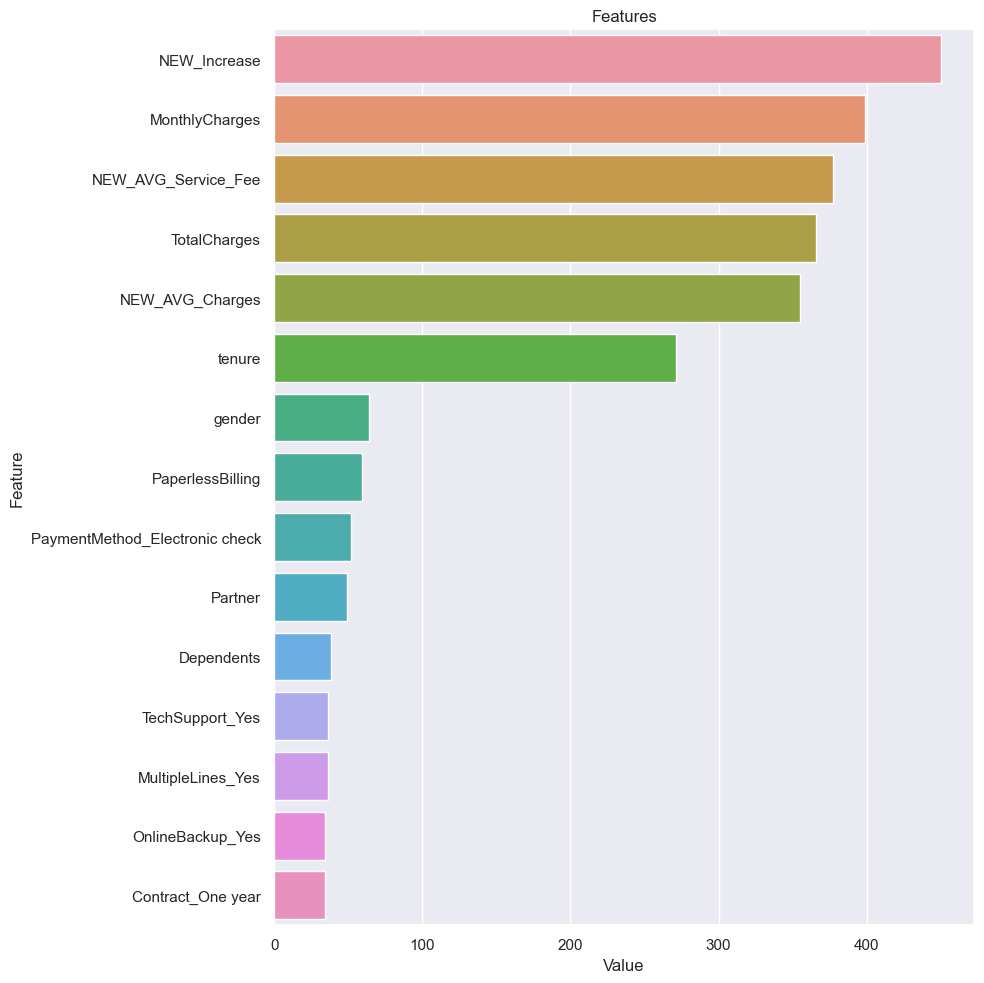

In [51]:
plot_importance(lgm, X, num=15)

In [52]:
delete_col = [col for col in df.columns if 'NEW_TENURE_YEAR' in col]
df.drop(delete_col, axis=1, inplace=True)

In [156]:
df_final = df.copy()
y = df["Churn"]
X = df.drop(["Churn","customerID"], axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=17)

In [150]:
lgbm_final = LGBMClassifier(random_state=17)

<div align="center" style="background-color: #865DFF; padding:10px;"><font color='#B3005E' size=5>Hyperparameter Tuning</font></div>

In [55]:
lgbm_final.get_params()

{'boosting_type': 'gbdt',
 'class_weight': None,
 'colsample_bytree': 1.0,
 'importance_type': 'split',
 'learning_rate': 0.1,
 'max_depth': -1,
 'min_child_samples': 20,
 'min_child_weight': 0.001,
 'min_split_gain': 0.0,
 'n_estimators': 100,
 'n_jobs': -1,
 'num_leaves': 31,
 'objective': None,
 'random_state': 17,
 'reg_alpha': 0.0,
 'reg_lambda': 0.0,
 'silent': 'warn',
 'subsample': 1.0,
 'subsample_for_bin': 200000,
 'subsample_freq': 0}

<h3 align="left"><font color='#00337C' size=5>GridSearchCV</font></h3>

In [56]:
lgbm_params = {"learning_rate": [0.05, 0.1, 0.2],
               "n_estimators": [100, 300, 500],
               "max_depth": [5, 10, -1],
               "num_leaves": [31, 63, 127],
               "min_child_samples": [20, 50],
               "feature_fraction": [0.5, 0.7, 0.9]}

In [57]:
lgbm_best_grid = GridSearchCV(lgbm_final, lgbm_params, cv=5, n_jobs=-1, verbose=True).fit(X_train, y_train)
lgbm_best_grid.best_params_

Fitting 5 folds for each of 486 candidates, totalling 2430 fits
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7


{'feature_fraction': 0.7,
 'learning_rate': 0.05,
 'max_depth': 5,
 'min_child_samples': 50,
 'n_estimators': 100,
 'num_leaves': 31}

In [58]:
lgbm_final = lgbm_final.set_params(**lgbm_best_grid.best_params_, random_state=17).fit(X_train, y_train)
y_pred = lgbm_final.predict(X_test)
print(f"########## LightGBM ##########")
print(f"Accuracy: {round(accuracy_score(y_test, y_pred), 4)}")
print(f"Auc: {round(roc_auc_score(y_test, y_pred), 4)}")
print(f"Recall: {round(recall_score(y_test, y_pred), 4)}")
print(f"Precision: {round(precision_score(y_test, y_pred), 4)}")
print(f"F1: {round(f1_score(y_test, y_pred), 4)}")

########## LightGBM ##########
Accuracy: 0.8043
Auc: 0.7215
Recall: 0.5493
Precision: 0.6445
F1: 0.5931


<h3 align="left"><font color='#00337C' size=5>Optuna</font></h3>

In [157]:
def objective(trial):
    lgbm_params = dict(
    max_depth = trial.suggest_int("max_depth", 3, 20, log=True),
    early_stopping_round = trial.suggest_int("early_stopping_rounds", 10, 40, log=True),
    scale_pos_weight = trial.suggest_float("scale_pos_weight", 2, 15, log=True),
    learning_rate = trial.suggest_float("learning_rate", 0.001, 0.1, log=True),
    num_iterations=1000,
    random_state=41,
    verbosity=-99)
    
    lgbm_final = LGBMClassifier(**lgbm_params).fit(X_train, y_train, eval_set=(X_test, y_test),
                                                  eval_metric="f1",verbose=-99)
    y_pred = lgbm_final.predict(X_test)
    score = f1_score(y_true = y_test, y_pred = y_pred)
    return score
    
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=100)

[I 2023-04-27 17:15:40,510] A new study created in memory with name: no-name-4a58a0ee-da20-4c77-9e60-c9aa41fcb6fc
[I 2023-04-27 17:15:40,603] Trial 0 finished with value: 0.6139088729016787 and parameters: {'max_depth': 6, 'early_stopping_rounds': 15, 'scale_pos_weight': 4.168298154591201, 'learning_rate': 0.08624135744243558}. Best is trial 0 with value: 0.6139088729016787.
[I 2023-04-27 17:15:42,730] Trial 1 finished with value: 0.6079136690647482 and parameters: {'max_depth': 14, 'early_stopping_rounds': 11, 'scale_pos_weight': 2.10416341611873, 'learning_rate': 0.0011448214607681112}. Best is trial 0 with value: 0.6139088729016787.
[I 2023-04-27 17:15:43,071] Trial 2 finished with value: 0.5078651685393258 and parameters: {'max_depth': 16, 'early_stopping_rounds': 11, 'scale_pos_weight': 9.805646572636888, 'learning_rate': 0.003459769841125871}. Best is trial 0 with value: 0.6139088729016787.
[I 2023-04-27 17:15:44,167] Trial 3 finished with value: 0.0 and parameters: {'max_depth':

[I 2023-04-27 17:15:58,485] Trial 29 finished with value: 0.6164931945556446 and parameters: {'max_depth': 7, 'early_stopping_rounds': 16, 'scale_pos_weight': 4.370965452507966, 'learning_rate': 0.0029910109215937827}. Best is trial 7 with value: 0.6243739565943238.
[I 2023-04-27 17:15:59,243] Trial 30 finished with value: 0.619332763045338 and parameters: {'max_depth': 10, 'early_stopping_rounds': 23, 'scale_pos_weight': 2.005965869516682, 'learning_rate': 0.005202722233395404}. Best is trial 7 with value: 0.6243739565943238.
[I 2023-04-27 17:15:59,766] Trial 31 finished with value: 0.6206322795341097 and parameters: {'max_depth': 15, 'early_stopping_rounds': 20, 'scale_pos_weight': 2.3261403266904352, 'learning_rate': 0.007414440228026578}. Best is trial 7 with value: 0.6243739565943238.
[I 2023-04-27 17:16:01,808] Trial 32 finished with value: 0.6216216216216216 and parameters: {'max_depth': 13, 'early_stopping_rounds': 23, 'scale_pos_weight': 2.2932363934500355, 'learning_rate': 0.

[I 2023-04-27 17:16:29,172] Trial 59 finished with value: 0.6218905472636816 and parameters: {'max_depth': 19, 'early_stopping_rounds': 20, 'scale_pos_weight': 2.4124339927563128, 'learning_rate': 0.0031795139833925515}. Best is trial 7 with value: 0.6243739565943238.
[I 2023-04-27 17:16:29,930] Trial 60 finished with value: 0.6230323115161558 and parameters: {'max_depth': 17, 'early_stopping_rounds': 32, 'scale_pos_weight': 2.5956529709911633, 'learning_rate': 0.004611990656060333}. Best is trial 7 with value: 0.6243739565943238.
[I 2023-04-27 17:16:30,958] Trial 61 finished with value: 0.6238377007607777 and parameters: {'max_depth': 19, 'early_stopping_rounds': 22, 'scale_pos_weight': 2.1682971869282373, 'learning_rate': 0.003999192924650401}. Best is trial 7 with value: 0.6243739565943238.
[I 2023-04-27 17:16:32,065] Trial 62 finished with value: 0.6218487394957983 and parameters: {'max_depth': 18, 'early_stopping_rounds': 22, 'scale_pos_weight': 2.170762867402845, 'learning_rate':

[I 2023-04-27 17:17:02,197] Trial 89 finished with value: 0.6212624584717609 and parameters: {'max_depth': 17, 'early_stopping_rounds': 18, 'scale_pos_weight': 2.5294802936857663, 'learning_rate': 0.003360496961048262}. Best is trial 80 with value: 0.6246851385390428.
[I 2023-04-27 17:17:03,360] Trial 90 finished with value: 0.6186234817813765 and parameters: {'max_depth': 18, 'early_stopping_rounds': 17, 'scale_pos_weight': 2.882578249722805, 'learning_rate': 0.002262764112696124}. Best is trial 80 with value: 0.6246851385390428.
[I 2023-04-27 17:17:04,056] Trial 91 finished with value: 0.6227045075125209 and parameters: {'max_depth': 12, 'early_stopping_rounds': 20, 'scale_pos_weight': 2.2430589666913927, 'learning_rate': 0.005620932217435266}. Best is trial 80 with value: 0.6246851385390428.
[I 2023-04-27 17:17:04,901] Trial 92 finished with value: 0.6212624584717609 and parameters: {'max_depth': 20, 'early_stopping_rounds': 20, 'scale_pos_weight': 2.392673407930722, 'learning_rate'

In [158]:
# Bulunan en iyi parametreler
study.best_params

{'max_depth': 19,
 'early_stopping_rounds': 15,
 'scale_pos_weight': 2.253353141029463,
 'learning_rate': 0.001784739168277737}

In [159]:
params = study.best_params
params["num_iterations"] = 1000
params["random_state"] = 41
params["verbosity"] = -99
params

{'max_depth': 19,
 'early_stopping_rounds': 15,
 'scale_pos_weight': 2.253353141029463,
 'learning_rate': 0.001784739168277737,
 'num_iterations': 1000,
 'random_state': 41,
 'verbosity': -99}

In [160]:
lgb_final = LGBMClassifier(**params).fit(X_train, y_train, eval_set=(X_test, y_test), eval_metric="f1", 
                                         verbose=-99)

[LightGBM] [Warning] early_stopping_round is set=15, early_stopping_rounds=15 will be ignored. Current value: early_stopping_round=15


In [161]:
y_pred = lgb_final.predict(X_test)

print(f"Accuracy: {round(accuracy_score(y_test, y_pred), 4)}")
print(f"Auc: {round(roc_auc_score(y_test, y_pred), 4)}")
print(f"Recall: {round(recall_score(y_test, y_pred), 4)}")
print(f"Precision: {round(precision_score(y_test, y_pred), 4)}")
print(f"F1: {round(f1_score(y_test, y_pred), 4)}")

Accuracy: 0.7882
Auc: 0.7527
Recall: 0.6788
Precision: 0.5785
F1: 0.6247


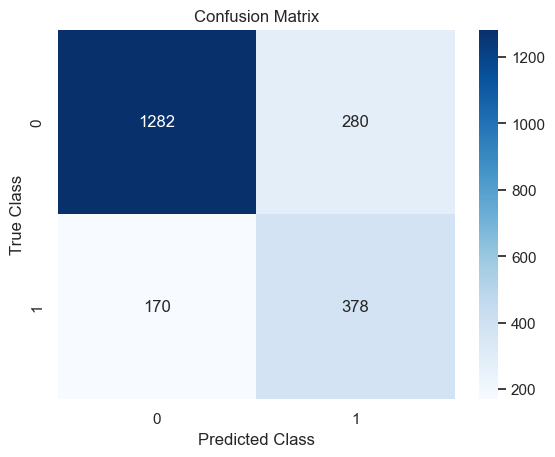

In [137]:
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Class')
plt.ylabel('True Class')
plt.show()

In [116]:
values = pd.Series(y_test).reset_index(drop=True)
predictions = pd.Series(y_pred).reset_index(drop=True)
pd.concat([values, predictions], axis=1, keys=['Values', 'Predictions'])[0:10]

,Values,Predictions
0,1,1
1,0,0
2,0,0
3,0,0
4,1,1
5,0,0
6,0,1
7,1,0
8,1,1
9,0,0
